## MOOC 학습자 이탈 예측 모델 개발

### 데이터셋 다운로드

In [1]:
import kagglehub
import os
import pandas as pd

dataset_path = kagglehub.dataset_download("rocki37/open-university-learning-analytics-dataset")
print("Dataset downloaded to:", dataset_path)

data_folder = "data"
os.makedirs(data_folder, exist_ok=True)

files = os.listdir(dataset_path)
csv_files = [f for f in files if f.endswith('.csv')]
print("Found CSV files:", csv_files)

saved_files = []
for csv_file in csv_files:
    src_path = os.path.join(dataset_path, csv_file) 
    dest_path = os.path.join(data_folder, csv_file) 
    df = pd.read_csv(src_path) 
    df.to_csv(dest_path, index=False)
    saved_files.append(dest_path)
    print(f"Saved {csv_file} to {dest_path}")

Dataset downloaded to: C:\Users\Playdata\.cache\kagglehub\datasets\rocki37\open-university-learning-analytics-dataset\versions\1
Found CSV files: ['assessments.csv', 'courses.csv', 'studentAssessment.csv', 'studentInfo.csv', 'studentRegistration.csv', 'studentVle.csv', 'vle.csv']
Saved assessments.csv to data\assessments.csv
Saved courses.csv to data\courses.csv
Saved studentAssessment.csv to data\studentAssessment.csv
Saved studentInfo.csv to data\studentInfo.csv
Saved studentRegistration.csv to data\studentRegistration.csv
Saved studentVle.csv to data\studentVle.csv
Saved vle.csv to data\vle.csv


### 데이터 로드

In [2]:
studentInfo_df = pd.read_csv('./data/studentInfo.csv')[["id_student", "code_module", "highest_education", "studied_credits", "imd_band", "final_result"]]
studentVle_df = pd.read_csv('./data/studentVle.csv')[["id_student", "sum_click", "date"]]
studentAssessment_df = pd.read_csv('./data/studentAssessment.csv')[["id_assessment","id_student", "score"]]
final_merged_data = pd.merge(studentInfo_df, studentAssessment_df, on='id_student', how='inner')

studentVle_agg = studentVle_df.groupby('id_student').agg(
    sum_click=('sum_click', 'sum'),  
    mean_click=('sum_click', 'mean')
).reset_index()

final_merged_data = pd.merge(final_merged_data, studentVle_agg, on='id_student', how='left')

final_merged_data['sum_click'] = final_merged_data['sum_click'].fillna(0)
final_merged_data['mean_click'] = final_merged_data['mean_click'].fillna(0)

### 데이터 전처리

In [3]:
final_merged_data['imd_band'] = final_merged_data['imd_band'].fillna('20-30%')
final_merged_data['score'] = final_merged_data['score'].fillna(0)
final_merged_data['imd_band'] = final_merged_data['imd_band'].replace('10-20', '10-20%')
final_merged_data.to_csv('./data/merged_data.csv', index=False)

### 데이터 분석 및 시각화

In [4]:
withdrawn_rate = final_merged_data["final_result"].value_counts(normalize=True) * 100
print("📌 이탈률 분포:\n", withdrawn_rate)

📌 이탈률 분포:
 final_result
Pass           56.929177
Fail           15.905923
Distinction    14.636382
Withdrawn      12.528519
Name: proportion, dtype: float64


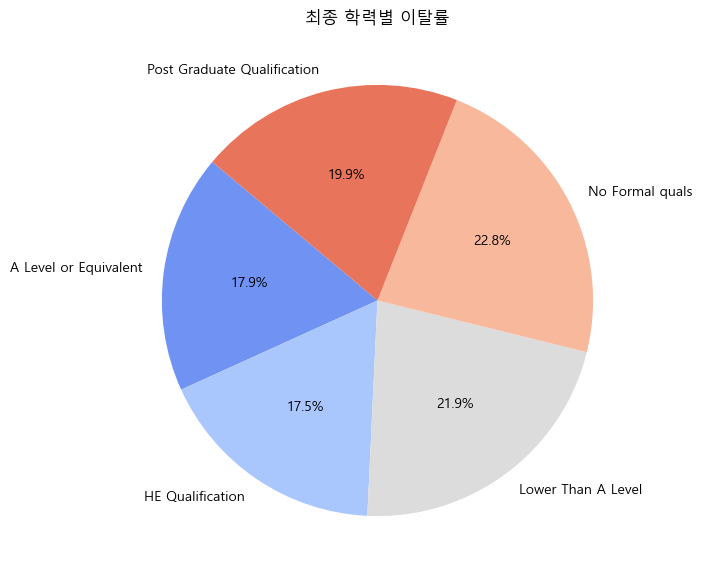

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import matplotlib

font_path = 'C:/Windows/Fonts/malgunbd.ttf'
font = fm.FontProperties(fname=font_path).get_name()
matplotlib.rc('font', family=font)

# font_name = "Apple SD Gothic Neo"
# matplotlib.rc('font', family=font_name)

palette = {"Withdrawn": "red", "Pass": "blue", "Fail": "orange", "Distinction": "green"}

education_withdrawn = final_merged_data.groupby("highest_education")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100
plt.figure(figsize=(7, 7))
plt.pie(education_withdrawn.values, labels=education_withdrawn.index, autopct='%1.1f%%', colors=sns.color_palette("coolwarm", len(education_withdrawn)), startangle=140)
plt.title("최종 학력별 이탈률")
plt.show()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_19084\1184413172.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=education_withdrawn.index, y=education_withdrawn.values, palette="coolwarm")


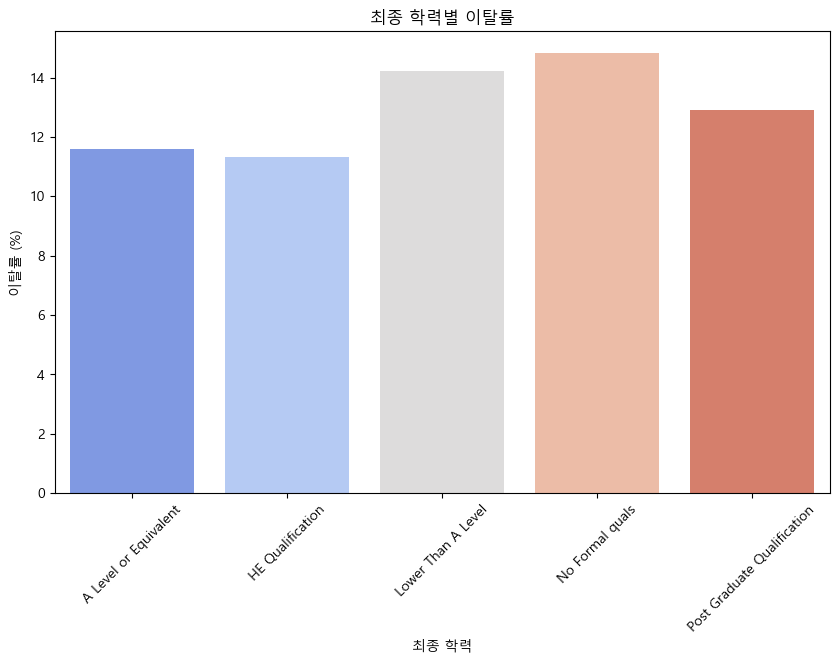

In [6]:
plt.figure(figsize=(10, 6))
education_withdrawn = final_merged_data.groupby("highest_education")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100
sns.barplot(x=education_withdrawn.index, y=education_withdrawn.values, palette="coolwarm")
plt.title("최종 학력별 이탈률")
plt.xlabel("최종 학력")
plt.ylabel("이탈률 (%)")
plt.xticks(rotation=45)
plt.show()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_19084\2892628582.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=imd_withdrawn.index, x=imd_withdrawn.values, palette="coolwarm")


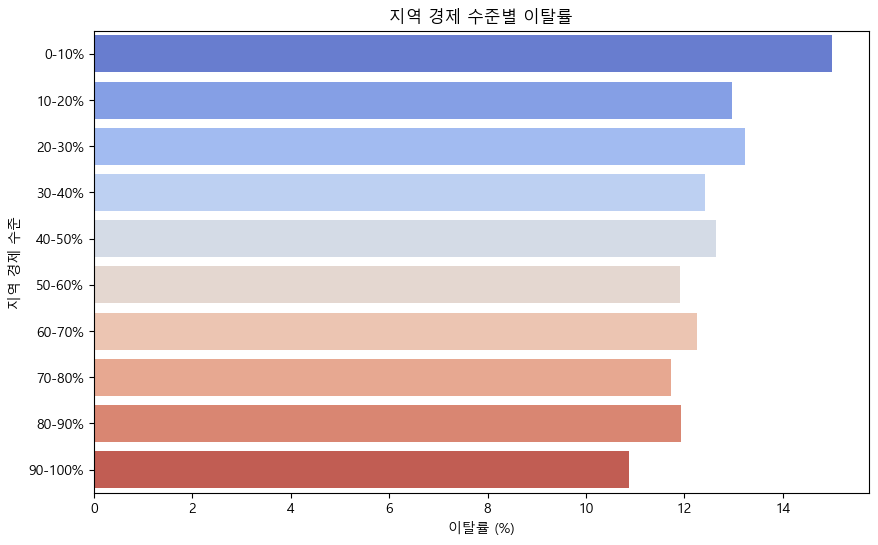

In [7]:
imd_withdrawn = final_merged_data.groupby("imd_band")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100
plt.figure(figsize=(10, 6))
sns.barplot(y=imd_withdrawn.index, x=imd_withdrawn.values, palette="coolwarm")
plt.title("지역 경제 수준별 이탈률")
plt.xlabel("이탈률 (%)")
plt.ylabel("지역 경제 수준")
plt.show()

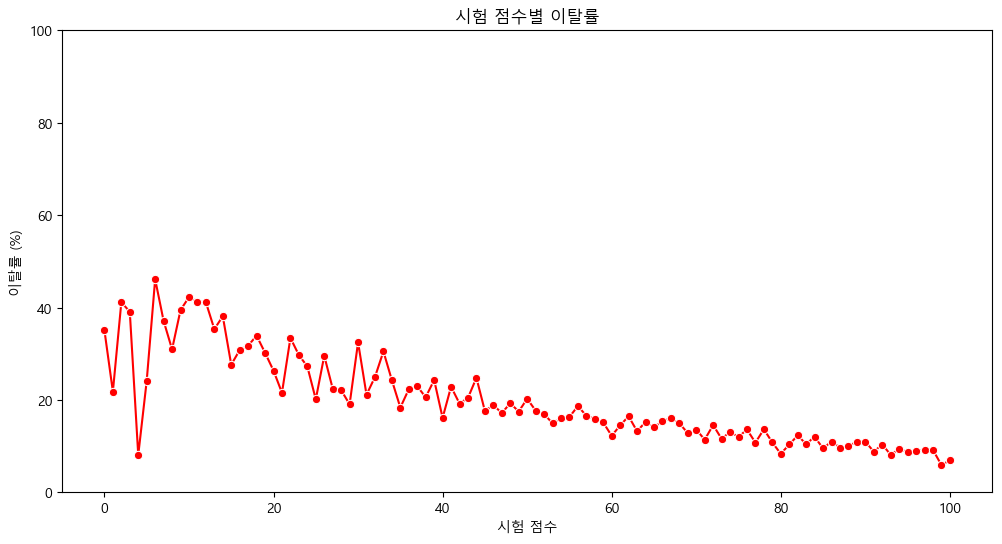

In [8]:
plt.figure(figsize=(12, 6))
score_withdrawn = final_merged_data.groupby("score")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100
sns.lineplot(x=score_withdrawn.index, y=score_withdrawn.values, color="red", marker="o")
plt.title("시험 점수별 이탈률")
plt.xlabel("시험 점수")
plt.ylabel("이탈률 (%)")
plt.ylim(0, 100)
plt.show()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_19084\2119123669.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  score_withdrawn = final_merged_data.groupby("score_bins")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100


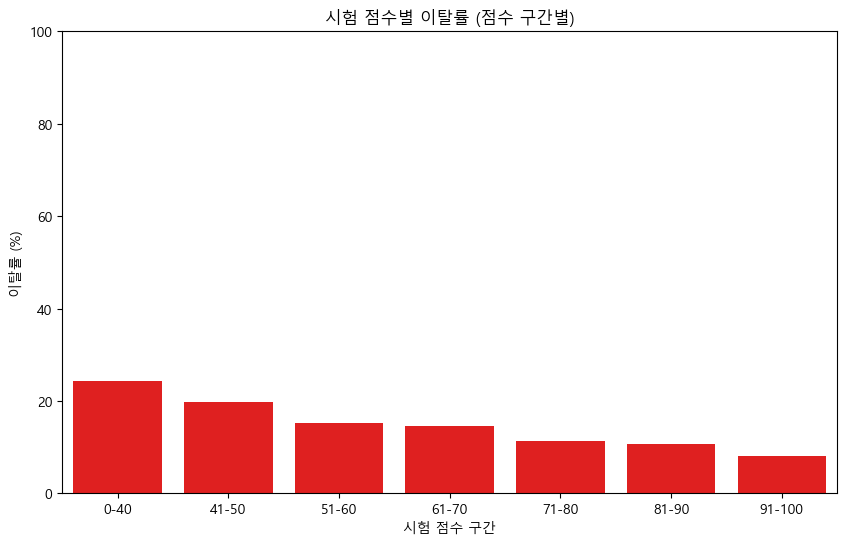

In [9]:
final_merged_data["score_bins"] = pd.cut(final_merged_data["score"], bins=[0, 40, 50, 60, 70, 80, 90, 100], labels=["0-40", "41-50", "51-60", "61-70", "71-80", "81-90", "91-100"])
score_withdrawn = final_merged_data.groupby("score_bins")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100

plt.figure(figsize=(10, 6))
sns.barplot(x=score_withdrawn.index, y=score_withdrawn.values, color="red")
plt.title("시험 점수별 이탈률 (점수 구간별)")
plt.xlabel("시험 점수 구간")
plt.ylabel("이탈률 (%)")
plt.ylim(0, 100) 
plt.show()

C:\Users\Playdata\AppData\Local\Temp\ipykernel_19084\1035278623.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  credit_withdrawn = final_merged_data.groupby("credit_bins")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100


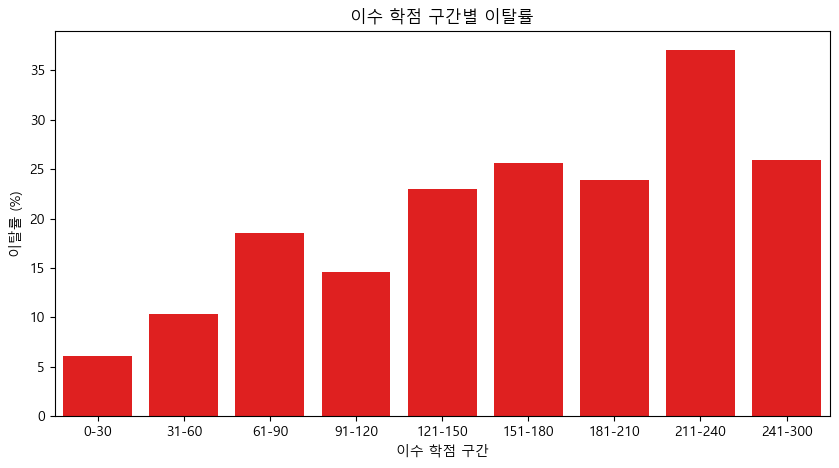

In [10]:
final_merged_data["credit_bins"] = pd.cut(final_merged_data["studied_credits"], bins=[0, 30, 60, 90, 120, 150, 180, 210, 240, 300], labels=["0-30", "31-60", "61-90", "91-120", "121-150", "151-180", "181-210", "211-240", "241-300"])
credit_withdrawn = final_merged_data.groupby("credit_bins")["final_result"].apply(lambda x: (x == "Withdrawn").mean()) * 100

plt.figure(figsize=(10, 5))
sns.barplot(x=credit_withdrawn.index, y=credit_withdrawn.values, color="red")
plt.title("이수 학점 구간별 이탈률")
plt.xlabel("이수 학점 구간")
plt.ylabel("이탈률 (%)")
plt.show()

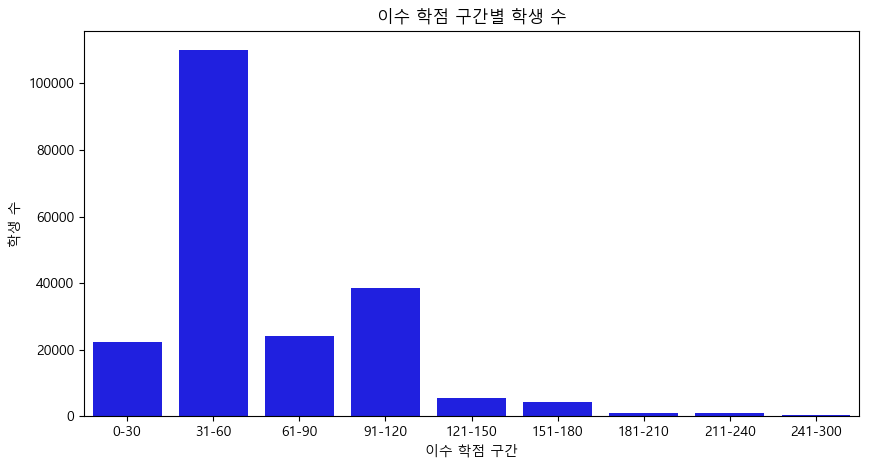

In [11]:
credit_counts = final_merged_data["credit_bins"].value_counts().sort_index()

plt.figure(figsize=(10, 5))
sns.barplot(x=credit_counts.index, y=credit_counts.values, color="blue")
plt.title("이수 학점 구간별 학생 수")
plt.xlabel("이수 학점 구간")
plt.ylabel("학생 수")
plt.show()

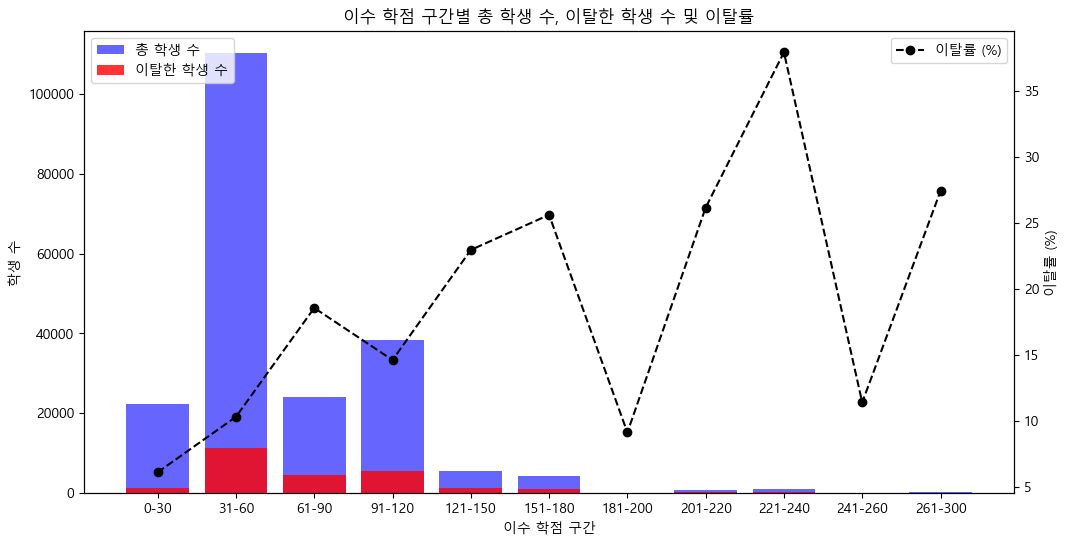

In [12]:
final_merged_data["credit_bins"] = pd.cut(final_merged_data["studied_credits"], bins=[0, 30, 60, 90, 120, 150, 180, 200, 220, 240, 260, 300], 
                                          labels=["0-30", "31-60", "61-90", "91-120", "121-150", "151-180", "181-200", "201-220", "221-240", "241-260", "261-300"])

credit_counts = final_merged_data["credit_bins"].value_counts().sort_index()
credit_withdrawn_counts = final_merged_data[final_merged_data["final_result"] == "Withdrawn"]["credit_bins"].value_counts().sort_index()

credit_df = pd.DataFrame({"총 학생 수": credit_counts, "이탈한 학생 수": credit_withdrawn_counts}).fillna(0)
credit_df["이탈률 (%)"] = (credit_df["이탈한 학생 수"] / credit_df["총 학생 수"]) * 100

fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.bar(credit_df.index, credit_df["총 학생 수"], color="blue", alpha=0.6, label="총 학생 수")
ax1.bar(credit_df.index, credit_df["이탈한 학생 수"], color="red", alpha=0.8, label="이탈한 학생 수")
ax1.set_ylabel("학생 수")
ax1.set_xlabel("이수 학점 구간")
ax1.legend(loc="upper left")

ax2 = ax1.twinx()
ax2.plot(credit_df.index, credit_df["이탈률 (%)"], color="black", marker="o", linestyle="dashed", label="이탈률 (%)")
ax2.set_ylabel("이탈률 (%)")
ax2.legend(loc="upper right")

plt.title("이수 학점 구간별 총 학생 수, 이탈한 학생 수 및 이탈률")
plt.show()

In [13]:
final_merged_data = final_merged_data.drop(columns=['score_bins', 'credit_bins'], axis=1)


### Data Labeling

- final_result 컬럼을 이진 분류(Binary Classification) 형태로 변환.
- Withdrawn (중도 포기) → 0, 그 외 (Distinction, Fail, Pass) → 1
- 0 = 학습 포기 (Withdrawn)
- 1 = 학습 지속 (Pass, Fail, Distinction)
- code_module과 imd_band는 범주형 변수는 LabelEncoder()를 사용하여 각각의 고유한 문자열을 숫자로 변환.         

In [14]:
from sklearn.preprocessing import LabelEncoder

new_education_encodings = {
    'Post Graduate Qualification': 0,
    'HE Qualification': 1,
    'A Level or Equivalent': 2,
    'Lower Than A Level': 3,
    'No Formal quals': 4
}

final_merged_data['highest_education'] = final_merged_data['highest_education'].map(new_education_encodings)

final_merged_data.head(5)

new_final_result_encodings = {
    'Withdrawn': 0,
    'Distinction': 1,
    'Fail': 1,
    'Pass': 1
}

final_merged_data['final_result'] = final_merged_data['final_result'].map(new_final_result_encodings)

final_merged_data.head(20)

final_merged_data = final_merged_data.copy()
label_encoder = LabelEncoder()

categorical_columns = ["code_module", "imd_band",]
for col in categorical_columns:
    final_merged_data[col] = label_encoder.fit_transform(final_merged_data[col])

Text(0, 0.5, '빈도')

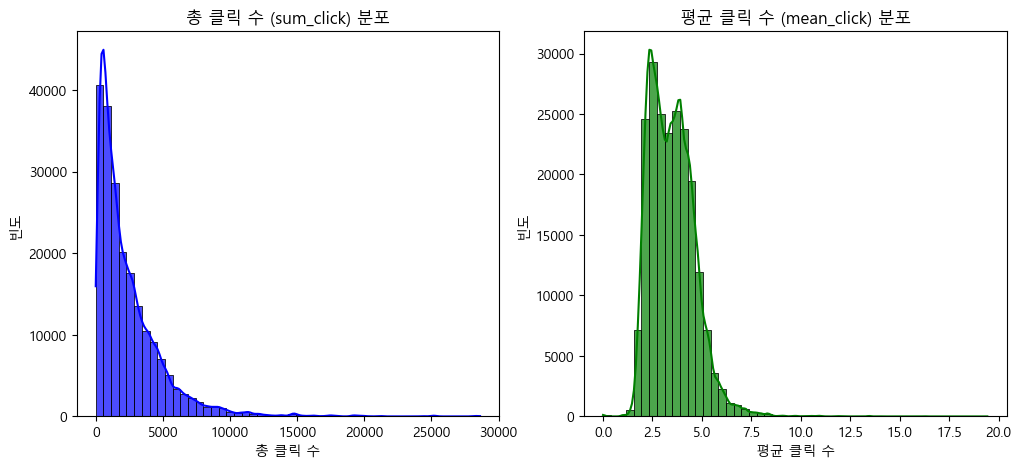

In [15]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.histplot(final_merged_data["sum_click"], bins=50, kde=True, color="blue", alpha=0.7)
plt.title("총 클릭 수 (sum_click) 분포")
plt.xlabel("총 클릭 수")
plt.ylabel("빈도")

plt.subplot(1, 2, 2)
sns.histplot(final_merged_data["mean_click"], bins=50, kde=True, color="green", alpha=0.7)
plt.title("평균 클릭 수 (mean_click) 분포")
plt.xlabel("평균 클릭 수")
plt.ylabel("빈도")

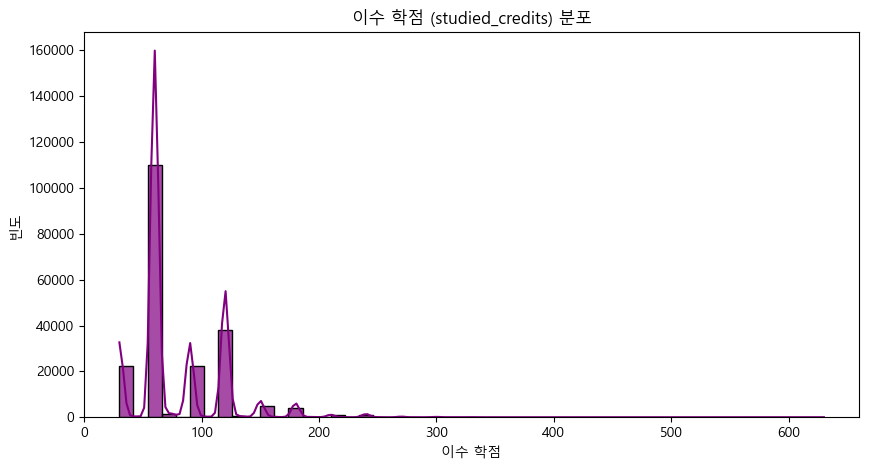

In [16]:
plt.figure(figsize=(10, 5))
sns.histplot(final_merged_data["studied_credits"], bins=50, kde=True, color="purple", alpha=0.7)
plt.title("이수 학점 (studied_credits) 분포")
plt.xlabel("이수 학점")
plt.ylabel("빈도")
plt.show()

### Data Scaling

- sum_click (총 클릭 수) → 오른쪽 꼬리가 긴 비대칭 분포 (Right-skewed)
- mean_click (평균 클릭 수) → 완만한 비대칭 분포지만, 특정 범위에 밀집

따라서, 분포를 정규 분포에 가깝게 변형하는 Log Scaling 진행

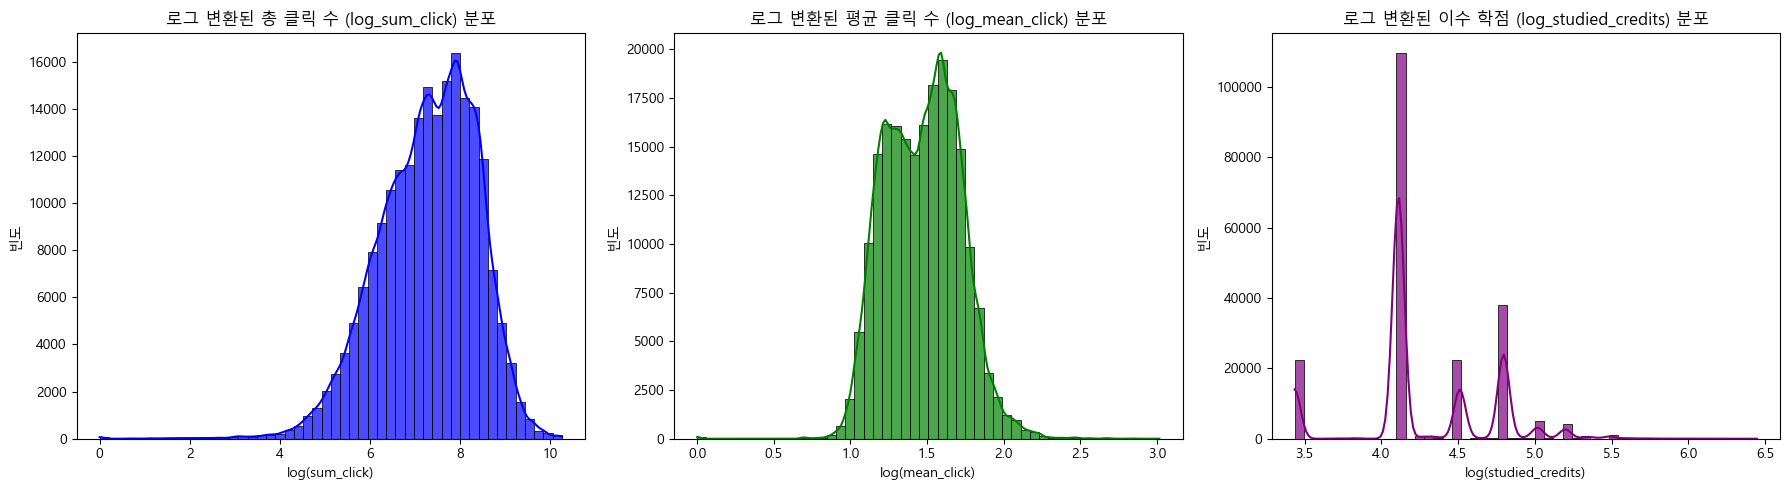

In [17]:
import numpy as np

final_merged_data["log_sum_click"] = np.log1p(final_merged_data["sum_click"])
final_merged_data["log_mean_click"] = np.log1p(final_merged_data["mean_click"])
final_merged_data["log_studied_credits"] = np.log1p(final_merged_data["studied_credits"])

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(final_merged_data["log_sum_click"], bins=50, kde=True, color="blue", alpha=0.7)
plt.title("로그 변환된 총 클릭 수 (log_sum_click) 분포")
plt.xlabel("log(sum_click)")
plt.ylabel("빈도")

plt.subplot(1, 3, 2)
sns.histplot(final_merged_data["log_mean_click"], bins=50, kde=True, color="green", alpha=0.7)
plt.title("로그 변환된 평균 클릭 수 (log_mean_click) 분포")
plt.xlabel("log(mean_click)")
plt.ylabel("빈도")

plt.subplot(1, 3, 3)
sns.histplot(final_merged_data["log_studied_credits"], bins=50, kde=True, color="purple", alpha=0.7)
plt.title("로그 변환된 이수 학점 (log_studied_credits) 분포")
plt.xlabel("log(studied_credits)")
plt.ylabel("빈도")

plt.tight_layout()
plt.show()

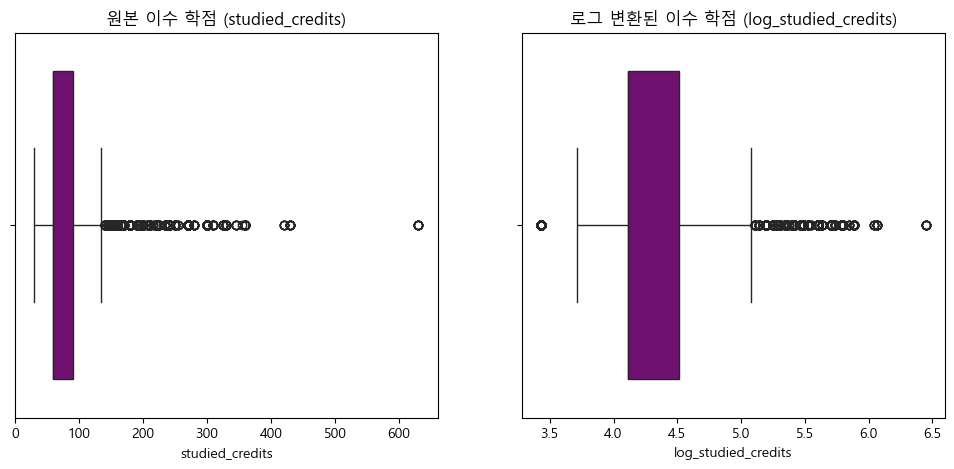

In [18]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.boxplot(x=final_merged_data["studied_credits"], color="purple")
plt.title("원본 이수 학점 (studied_credits)")

plt.subplot(1, 2, 2)
sns.boxplot(x=final_merged_data["log_studied_credits"], color="purple")
plt.title("로그 변환된 이수 학점 (log_studied_credits)")

plt.show()

In [19]:
final_merged_data = final_merged_data[final_merged_data["log_studied_credits"] > 3.5]

Text(0.5, 1.0, '로그 변환된 이수 학점 (log_studied_credits)')

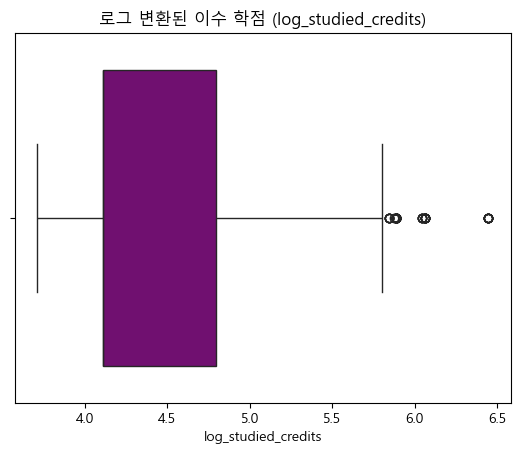

In [20]:
sns.boxplot(x=final_merged_data["log_studied_credits"], color="purple")
plt.title("로그 변환된 이수 학점 (log_studied_credits)")

#### MinMaxScaler
- 정규 분포를 따르지 않으므로 MinmaxScalar를 사용

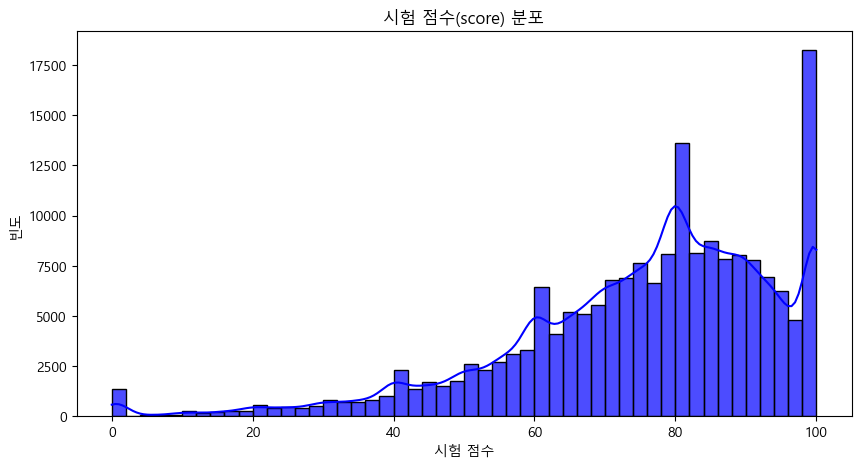

In [21]:
plt.figure(figsize=(10, 5))
sns.histplot(final_merged_data["score"], bins=50, kde=True, color="blue", alpha=0.7)
plt.title("시험 점수(score) 분포")
plt.xlabel("시험 점수")
plt.ylabel("빈도")
plt.show()

In [22]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
final_merged_data["scaled_studied_credits"] = scaler.fit_transform(final_merged_data[["studied_credits"]])
final_merged_data["scaled_score"] = scaler.fit_transform(final_merged_data[["score"]])

In [23]:
final_merged_data.to_csv('./data/final_merge_data', index=False)

### 학습 데이터

In [24]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

sum_clicked_features = ['highest_education', 'imd_band', 'log_sum_click', 'log_studied_credits', 'scaled_score']
mean_clicked_features = ['highest_education', 'imd_band', 'log_mean_click', 'log_studied_credits', 'scaled_score']

sum_x = final_merged_data[sum_clicked_features]
mean_x = final_merged_data[mean_clicked_features]
y = final_merged_data['final_result']

smote = SMOTE(sampling_strategy='auto', random_state=42)

sum_x_resampled, y_resampled = smote.fit_resample(sum_x, y)
mean_x_resampled, y_resampled = smote.fit_resample(mean_x, y)

sum_x_train, sum_x_test, y_train, y_test = train_test_split(sum_x_resampled, y_resampled, test_size=0.1, random_state=42, stratify=y_resampled)
mean_x_train, mean_x_test, y_train, y_test = train_test_split(mean_x_resampled, y_resampled, test_size=0.1, random_state=42, stratify=y_resampled)


### 모델 학습

In [25]:
from sklearn.tree import DecisionTreeClassifier  
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier   
from xgboost import XGBClassifier  
from lightgbm import LGBMClassifier  
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier

In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

def evaluate_clf(y_true, y_pred):
    print('정확도 평가')
    print('Accuracy :', accuracy_score(y_true, y_pred))
    print('F1 Score :', f1_score(y_true, y_pred, average='weighted'))
    print('Precision :', precision_score(y_true, y_pred, average='weighted'))
    print('Recall :', recall_score(y_true, y_pred, average='weighted'))

In [27]:
def evaluate_model(model_name, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    print(f"\n=== {model_name} 성능 ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(confusion_matrix(y_true, y_pred))
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

### Random Forest

In [28]:
rf_model_1 = RandomForestClassifier(
        random_state=42,
        n_estimators=124,
        max_depth=30,
        min_samples_split=11,
        min_samples_leaf=1,
        max_features=None,
        criterion='entropy'
    )

rf_model_1.fit(sum_x_train, y_train)
y_pred = rf_model_1.predict(sum_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.8992951596806387
F1 Score : 0.8992711531799215
Precision : 0.8996761757133585
Recall : 0.8992951596806387


In [29]:
rf_model_2 = RandomForestClassifier(
        random_state=42,
        n_estimators=124,
        max_depth=30,
        min_samples_split=11,
        min_samples_leaf=1,
        max_features=None,
        criterion='entropy'
    )

rf_model_2.fit(mean_x_train, y_train)
y_pred = rf_model_2.predict(mean_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.8950848303393214
F1 Score : 0.8950663078756176
Precision : 0.8953639824349413
Recall : 0.8950848303393214


### Gredient Boosting

In [30]:
gbm_model_1 = GradientBoostingClassifier(learning_rate= 0.15, 
                                       max_depth= 10,
                                       min_samples_leaf= 2, 
                                       min_samples_split= 5,
                                       n_estimators= 150, 
                                       random_state=42)
gbm_model_1.fit(sum_x_train, y_train)
y_pred = gbm_model_1.predict(sum_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.9023515469061876
F1 Score : 0.9020207782906843
Precision : 0.9078591226954562
Recall : 0.9023515469061876


In [31]:
gbm_model_2 = GradientBoostingClassifier(learning_rate= 0.15, 
                                       max_depth= 10,
                                       min_samples_leaf= 2, 
                                       min_samples_split= 5,
                                       n_estimators= 150, 
                                       random_state=42)
gbm_model_2.fit(mean_x_train, y_train)
y_pred = gbm_model_2.predict(mean_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.8846681636726547
F1 Score : 0.8840302926666745
Precision : 0.8933217525359218
Recall : 0.8846681636726547


### Decision Tree

In [32]:
dt_1 = DecisionTreeClassifier(max_depth= None, 
                            max_features= None,
                            min_samples_leaf= 1,
                            min_samples_split=2
                            )
dt_1.fit(sum_x_train, y_train)
y_pred = dt_1.predict(sum_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.892371506986028
F1 Score : 0.8923470791678167
Precision : 0.8927279668872521
Recall : 0.892371506986028


In [33]:
dt_2 = DecisionTreeClassifier(max_depth= None, 
                            max_features= None,
                            min_samples_leaf= 1,
                            min_samples_split=2
                            )
dt_2.fit(mean_x_train, y_train)
y_pred = dt_2.predict(mean_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.8832335329341318
F1 Score : 0.8832214613897192
Precision : 0.8833920598118437
Recall : 0.8832335329341318


### KNN

In [34]:
knn_1 = KNeighborsClassifier()
knn_1.fit(sum_x_train, y_train)
y_pred = knn_1.predict(sum_x_test)


evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.873440618762475
F1 Score : 0.8730360408149537
Precision : 0.8782620335367413
Recall : 0.873440618762475


In [35]:
knn_2 = KNeighborsClassifier()
knn_2.fit(mean_x_train, y_train)
y_pred = knn_2.predict(mean_x_test)


evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.8352045908183633
F1 Score : 0.8346028554382663
Precision : 0.8401546910845783
Recall : 0.8352045908183633


### XGB

In [36]:
xgb_model_1 = XGBClassifier(eval_metric='mlogloss')
xgb_model_1.fit(sum_x_train, y_train)
y_pred = xgb_model_1.predict(sum_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.8034555888223552
F1 Score : 0.8029261012788592
Precision : 0.8067522505653404
Recall : 0.8034555888223552


In [37]:
xgb_model = XGBClassifier(eval_metric='mlogloss')
xgb_model.fit(mean_x_train, y_train)
y_pred = xgb_model.predict(mean_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.7742015968063872
F1 Score : 0.7732510696135514
Precision : 0.7788777984619274
Recall : 0.7742015968063872


### LightGBM

In [38]:
lgbm_1 = LGBMClassifier(
    num_leaves=40,
    n_estimators=200,
    min_data_in_leaf=20,
    max_depth=10,
    learning_rate=0.2,
    feature_fraction=0.9,
    random_state=42) 

lgbm_1.fit(sum_x_train, y_train)
y_pred = lgbm_1.predict(sum_x_test)

evaluate_clf(y_test, y_pred)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 144286, number of negative: 144286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001171 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 288572, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[Lig

In [39]:
lgbm_2 = LGBMClassifier(
    num_leaves=40,
    n_estimators=200,
    min_data_in_leaf=20,
    max_depth=10,
    learning_rate=0.2,
    feature_fraction=0.9,
    random_state=42) 

lgbm_2.fit(mean_x_train, y_train)
y_pred = lgbm_2.predict(mean_x_test)

evaluate_clf(y_test, y_pred)

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 144286, number of negative: 144286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001182 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 288572, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[Lig

### Logistic Regression

In [40]:
LR1 = LogisticRegression(random_state=42, max_iter=1000, C= 0.01, solver= 'liblinear')
LR1.fit(sum_x_train, y_train)
y_pred = LR1.predict(sum_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.6153006487025948
F1 Score : 0.6149829877892992
Precision : 0.6156824270058852
Recall : 0.6153006487025948


In [41]:
LR2 = LogisticRegression(random_state=42, max_iter=1000, C= 0.01, solver= 'liblinear')
LR2.fit(mean_x_train, y_train)
y_pred = LR2.predict(mean_x_test)

evaluate_clf(y_test, y_pred)

정확도 평가
Accuracy : 0.6023889720558883
F1 Score : 0.601865185695256
Precision : 0.6029306344322465
Recall : 0.6023889720558883


#### 버전맞추기


In [42]:
# !pip install -U scikit-learn==1.2.2
# !pip install --upgrade xgboost lightgbm


### 앙상블

In [43]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42, n_estimators=124, max_depth=30, 
                                  min_samples_split=11, min_samples_leaf=1, 
                                  max_features=None, criterion='entropy')

gbm_model = GradientBoostingClassifier(learning_rate=0.15, max_depth=10, 
                                       min_samples_leaf=2, min_samples_split=5, 
                                       n_estimators=150, random_state=42)

dt_model = DecisionTreeClassifier(max_depth=None, max_features=None, 
                                  min_samples_leaf=1, min_samples_split=2)

knn_model = KNeighborsClassifier()

xgb_model = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False)

lgbm_model = LGBMClassifier(num_leaves=40, n_estimators=200, min_data_in_leaf=20, 
                            max_depth=10, learning_rate=0.2, feature_fraction=0.9, 
                            random_state=42)

lr_model = LogisticRegression(random_state=42, max_iter=1000, C=0.01, solver='liblinear')

base_learners = [
    ('rf', rf_model),
    ('gbm', gbm_model),
    ('dt', dt_model),
    ('knn', knn_model),
    ('xgb', xgb_model),
    ('lgbm', lgbm_model),
    ('lr', lr_model)
]

meta_model = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)
stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_model, passthrough=True)

sum_stacking_clf = stacking_clf.fit(sum_x_train, y_train)
sum_y_pred = sum_stacking_clf.predict(sum_x_test)
sum_reuslt = evaluate_clf(y_test, sum_y_pred)

mean_stacking_clf = stacking_clf.fit(mean_x_train, y_train)
mean_y_pred = sum_stacking_clf.predict(mean_x_test)
mean_reuslt = evaluate_clf(y_test, mean_y_pred)

print(sum_reuslt)
print(mean_reuslt)

c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:56:28] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 144286, number of negative: 144286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 288572, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:11:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:11:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:11:26] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 115428, number of negative: 115429
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000923 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 744
[LightGBM] [Info] Number of data points in the train set: 230857, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[Li

c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:11:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
정확도 평가
Accuracy : 0.9412425149700598
F1 Score : 0.9412422186950771
Precision : 0.9412514146767814
Recall : 0.9412425149700598


c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:15:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 144286, number of negative: 144286
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001305 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 288572, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:31:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:31:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 115428, number of negative: 115429
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001015 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 723
[LightGBM] [Info] Number of data points in the train set: 230857, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499998 -> initscore=-0.000009
[Li

c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:31:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
정확도 평가
Accuracy : 0.9214695608782435
F1 Score : 0.9214535349866487
Precision : 0.9218138127773249
Recall : 0.9214695608782435
None
None


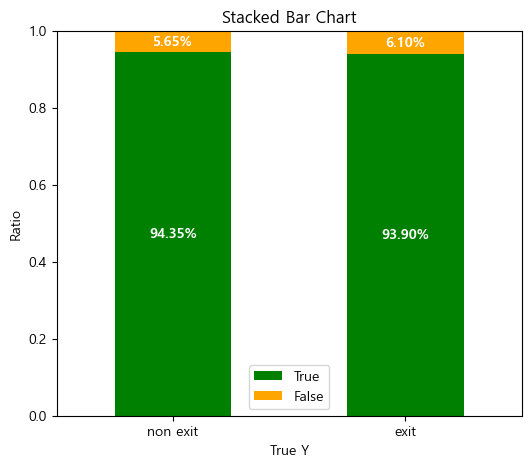

In [48]:
y1_pred_1 = np.sum((y_test == 1) & (sum_y_pred == 1)) / np.sum(y_test == 1)  
y1_pred_0 = np.sum((y_test == 1) & (sum_y_pred == 0)) / np.sum(y_test == 1)  

y0_pred_0 = np.sum((y_test == 0) & (sum_y_pred == 0)) / np.sum(y_test == 0)  
y0_pred_1 = np.sum((y_test == 0) & (sum_y_pred == 1)) / np.sum(y_test == 0)  


df = pd.DataFrame({
    "실제 Y 값": ["non exit", "exit"],
    "정답": [y1_pred_1, y0_pred_0],  
    "오답": [y1_pred_0, y0_pred_1]       
})

ax = df.set_index("실제 Y 값").plot(kind="bar", stacked=True, color=["green", "orange"], figsize=(6, 5))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_x(), p.get_y()
    if height > 0:
        ax.text(x + width / 2, y + height / 2, f"{height*100:.2f}%", ha="center", va="center", fontsize=10, color="white", fontweight="bold")


plt.xlabel("True Y")
plt.ylabel("Ratio")
plt.title("Stacked Bar Chart")
plt.xticks(rotation=0)
plt.legend(["True", "False"])
plt.ylim(0, 1)
plt.show()

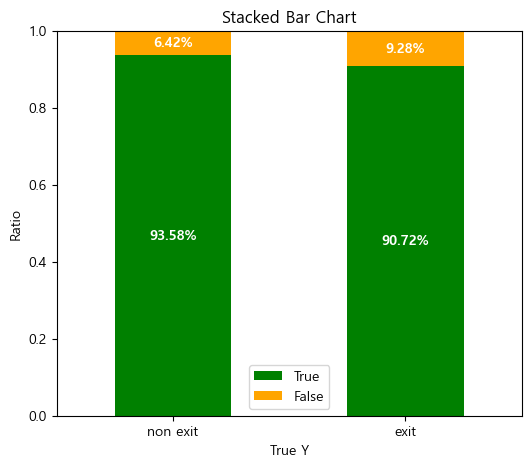

In [49]:
y1_pred_1 = np.sum((y_test == 1) & (mean_y_pred == 1)) / np.sum(y_test == 1)  
y1_pred_0 = np.sum((y_test == 1) & (mean_y_pred == 0)) / np.sum(y_test == 1)  

y0_pred_0 = np.sum((y_test == 0) & (mean_y_pred == 0)) / np.sum(y_test == 0)  
y0_pred_1 = np.sum((y_test == 0) & (mean_y_pred == 1)) / np.sum(y_test == 0)  


df = pd.DataFrame({
    "실제 Y 값": ["non exit", "exit"],
    "정답": [y1_pred_1, y0_pred_0],  
    "오답": [y1_pred_0, y0_pred_1]       
})

ax = df.set_index("실제 Y 값").plot(kind="bar", stacked=True, color=["green", "orange"], figsize=(6, 5))

for p in ax.patches:
    width, height = p.get_width(), p.get_height()
    x, y = p.get_x(), p.get_y()
    if height > 0:
        ax.text(x + width / 2, y + height / 2, f"{height*100:.2f}%", ha="center", va="center", fontsize=10, color="white", fontweight="bold")


plt.xlabel("True Y")
plt.ylabel("Ratio")
plt.title("Stacked Bar Chart")
plt.xticks(rotation=0)
plt.legend(["True", "False"])
plt.ylim(0, 1)
plt.show()

In [45]:
from sklearn.exceptions import NotFittedError

models = {
    "Random Forest (sum)": rf_model_1,
    "Random Forest (mean)": rf_model_2,
    "Gradient Boosting (sum)": gbm_model_1,
    "Gradient Boosting (mean)": gbm_model_2,
    "Decision Tree (sum)": dt_1,
    "Decision Tree (mean)": dt_2,
    "KNN (sum)": knn_1,
    "KNN (mean)": knn_2,
    "XGBoost (sum)": xgb_model_1,
    "XGBoost (mean)": xgb_model,
    "LightGBM (sum)": lgbm_1,
    "LightGBM (mean)": lgbm_2,
    "Logistic Regression (sum)": LR1,
    "Logistic Regression (mean)": LR2
}

model_results = []
for model_name, model in models.items():
    try:
        if not hasattr(model, "fit"):
            raise NotFittedError(f"⚠️ {model_name} 모델이 학습되지 않았습니다.")
        
        if not hasattr(model, "classes_"): 
            model.fit(sum_x_train if "sum" in model_name else mean_x_train, y_train)

        y_pred = model.predict(sum_x_test if "sum" in model_name else mean_x_test)

        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        model_results.append([model_name, accuracy, precision, recall, f1])

    except NotFittedError as e:
        print(e)

metrics_df = pd.DataFrame(model_results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
metrics_df


c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:31:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9


,Model,Accuracy,Precision,Recall,F1 Score
0,Random Forest (sum),0.899295,0.899676,0.899295,0.899271
1,Random Forest (mean),0.895085,0.895364,0.895085,0.895066
2,Gradient Boosting (sum),0.902352,0.907859,0.902352,0.902021
3,Gradient Boosting (mean),0.884668,0.893322,0.884668,0.884030
4,Decision Tree (sum),0.892372,0.892728,0.892372,0.892347
5,Decision Tree (mean),0.883234,0.883392,0.883234,0.883221
6,KNN (sum),0.873441,0.878262,0.873441,0.873036
7,KNN (mean),0.835205,0.840155,0.835205,0.834603
8,XGBoost (sum),0.803456,0.806752,0.803456,0.802926
9,XGBoost (mean),0.774202,0.778878,0.774202,0.773251


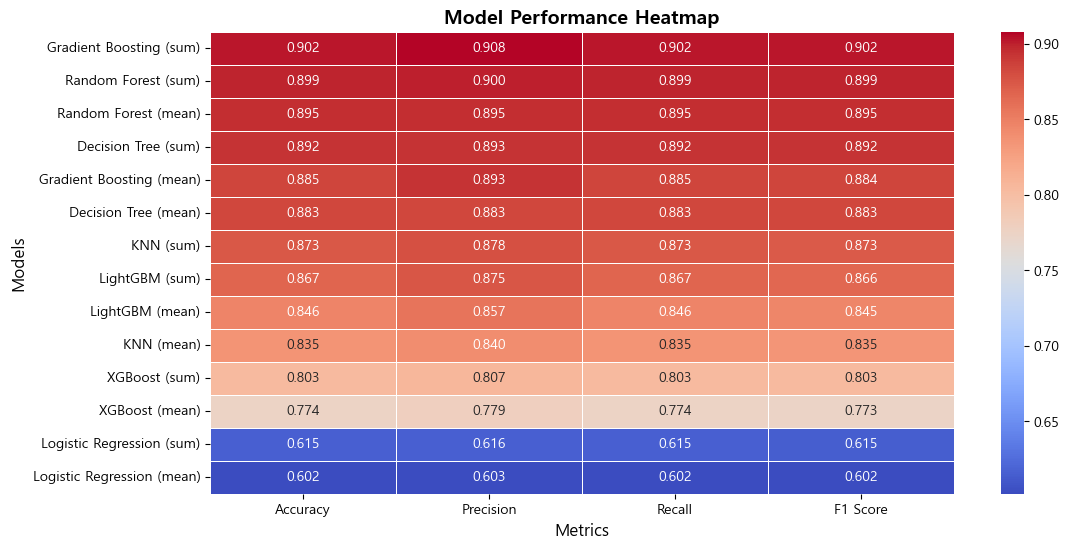

In [53]:
metrics_df_numeric = metrics_df.set_index("Model").astype(float)

metrics_df_numeric_sorted = metrics_df_numeric.sort_values(by="F1 Score", ascending=False)

plt.figure(figsize=(12, 6))
sns.heatmap(metrics_df_numeric_sorted, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5, cbar=True)

plt.title("Model Performance Heatmap", fontsize=14, fontweight='bold')
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Models", fontsize=12)

plt.show()


- 클래스 매핑 (0 → "Withdrawn", 1 → "Active")


In [ ]:
import pandas as pd

sum_x_test = sum_x_test.loc[y_test.index]
mean_x_test = mean_x_test.loc[y_test.index]

label_mapping = {0: "Withdrawn", 1: "Active"}

models_predictions = [
    ("Random Forest (sum)", rf_model_1.predict(sum_x_test)),
    ("Random Forest (mean)", rf_model_2.predict(mean_x_test)),
    ("Gradient Boosting (sum)", gbm_model_1.predict(sum_x_test)),
    ("Gradient Boosting (mean)", gbm_model_2.predict(mean_x_test)),
    ("Decision Tree (sum)", dt_1.predict(sum_x_test)),
    ("Decision Tree (mean)", dt_2.predict(mean_x_test)),
    ("KNN (sum)", knn_1.predict(sum_x_test)),
    ("KNN (mean)", knn_2.predict(mean_x_test)),
    ("XGBoost (sum)", xgb_model_1.predict(sum_x_test)),
    ("XGBoost (mean)", xgb_model.predict(mean_x_test)),
    ("LightGBM (sum)", lgbm_1.predict(sum_x_test)),
    ("LightGBM (mean)", lgbm_2.predict(mean_x_test)),
    ("Logistic Regression (sum)", LR1.predict(sum_x_test)),
    ("Logistic Regression (mean)", LR2.predict(mean_x_test))
]

common_indices = y_test.index.intersection(final_merged_data.index)

student_ids = final_merged_data.loc[common_indices, 'id_student']

test_results_df = pd.DataFrame({
    "Student_ID": student_ids,
    "Actual": y_test.loc[common_indices].map(label_mapping)
})

for model_name, y_pred in models_predictions:
    test_results_df[model_name] = pd.Series(y_pred, index=y_test.index).map(label_mapping)

csv_path = "data/model_results.csv"
test_results_df.to_csv(csv_path, index=False)

print(f"Model predictions saved to {csv_path}")


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
Model predictions saved to data/model_results.csv


### 추가 모델 파라미터 튜닝

In [ ]:
best_sum_params = {
    'subsample': 0.9,
    'n_estimators': 600,
    'min_samples_split': 5,
    'min_samples_leaf': 1,
    'max_features': None,
    'max_depth': 9,
    'learning_rate': 0.15,
    'random_state': 42
}

best_mean_params = {
    'subsample': 0.8,
    'n_estimators': 600,
    'min_samples_split': 10,
    'min_samples_leaf': 4,
    'max_features': None,
    'max_depth': 9,
    'learning_rate': 0.1,
    'random_state': 42
}

tuned_gbm_sum_model = GradientBoostingClassifier(**best_sum_params)
tuned_gbm_sum_model.fit(sum_x_train , y_train)
y_pred_best_sum = tuned_gbm_sum_model.predict(sum_x_test)

tuned_gbm_mean_model = GradientBoostingClassifier(**best_mean_params)
tuned_gbm_mean_model.fit(mean_x_train , y_train)
y_pred_best_mean = tuned_gbm_mean_model.predict(mean_x_test)

evaluate_model("Best Sum Click 기반 Gradient Boosting", y_test, y_pred_best_sum)
evaluate_model("Best Mean Click 기반 Gradient Boosting", y_test, y_pred_best_mean)

plt.figure(figsize=(10, 5))
feature_importances_sum = pd.Series(tuned_gbm_sum_model.feature_importances_, index=sum_clicked_features).sort_values(ascending=False)
sns.barplot(x=feature_importances_sum, y=feature_importances_sum.index, palette='viridis')
plt.title("Feature Importance - Sum Click Based Gradient Boosting (Optimized)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

plt.figure(figsize=(10, 5))
feature_importances_mean = pd.Series(tuned_gbm_mean_model.feature_importances_, index=mean_clicked_features).sort_values(ascending=False)
sns.barplot(x=feature_importances_mean, y=feature_importances_mean.index, palette='viridis')
plt.title("Feature Importance - Mean Click Based Gradient Boosting (Optimized)")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.show()

[LightGBM] [Info] Number of positive: 144286, number of negative: 22138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 166424, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.866978 -> initscore=1.874502
[LightGBM] [Info] Start training from score 1.874502
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

C:\Users\Playdata\AppData\Local\Temp\ipykernel_21652\682148459.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_sum, y=feature_importances_sum.index, palette='viridis')


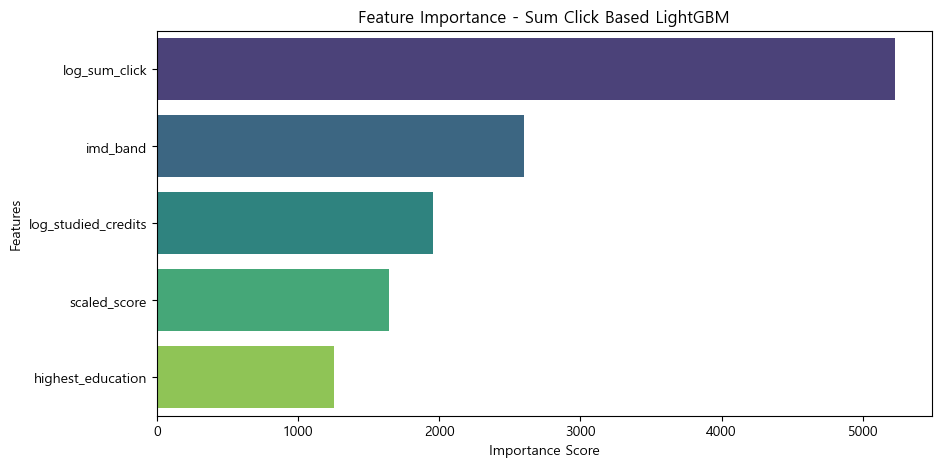

C:\Users\Playdata\AppData\Local\Temp\ipykernel_21652\682148459.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_mean, y=feature_importances_mean.index, palette='viridis')


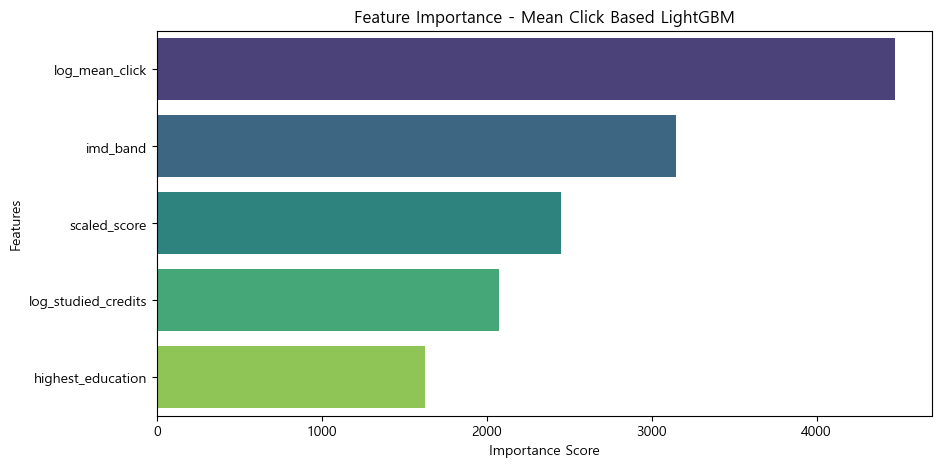

In [ ]:
best_sum_params = {
    'subsample': 0.7,
    'reg_lambda': 0.1,
    'reg_alpha': 0.5,
    'num_leaves': 31,
    'n_estimators': 500,
    'min_child_samples': 30,
    'max_depth': 5,
    'learning_rate': 0.15,
    'colsample_bytree': 1.0,
    'random_state': 42
}

best_mean_params = {
    'subsample': 0.7,
    'reg_lambda': 1.0,
    'reg_alpha': 0.1,
    'num_leaves': 100,
    'n_estimators': 200,
    'min_child_samples': 20,
    'max_depth': 7,
    'learning_rate': 0.15,
    'colsample_bytree': 0.8,
    'random_state': 42
}

turned_lgbm_sum_model = LGBMClassifier(**best_sum_params)
turned_lgbm_sum_model.fit(sum_x_train, y_train)
y_pred_best_sum = turned_lgbm_sum_model.predict(sum_x_test)

turned_lgbm_mean_model = LGBMClassifier(**best_mean_params)
turned_lgbm_mean_model.fit(mean_x_train, y_train)
y_pred_best_mean = turned_lgbm_mean_model.predict(mean_x_test)

evaluate_model("Best Sum Click 기반 LightGBM", y_test, y_pred_best_sum)
evaluate_model("Best Mean Click 기반 LightGBM", y_test, y_pred_best_mean)

plt.figure(figsize=(10, 5))
feature_importances_sum = pd.Series(turned_lgbm_sum_model.feature_importances_, index=sum_clicked_features).sort_values(ascending=False)
sns.barplot(x=feature_importances_sum, y=feature_importances_sum.index, palette='viridis')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance - Sum Click Based LightGBM")
plt.show()

plt.figure(figsize=(10, 5))
feature_importances_mean = pd.Series(turned_lgbm_mean_model.feature_importances_, index=mean_clicked_features).sort_values(ascending=False)
sns.barplot(x=feature_importances_mean, y=feature_importances_mean.index, palette='viridis')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance - Mean Click Based LightGBM")
plt.show()


=== Best Sum Click 기반 Random Forest 성능 ===
Accuracy: 0.8833
F1 Score: 0.8590
Confusion Matrix:
[[  602  1858]
 [  300 15732]]
Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.24      0.36      2460
           1       0.89      0.98      0.94     16032

    accuracy                           0.88     18492
   macro avg       0.78      0.61      0.65     18492
weighted avg       0.86      0.88      0.86     18492


=== Best Mean Click 기반 Random Forest 성능 ===
Accuracy: 0.8822
F1 Score: 0.8550
Confusion Matrix:
[[  539  1921]
 [  258 15774]]
Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.22      0.33      2460
           1       0.89      0.98      0.94     16032

    accuracy                           0.88     18492
   macro avg       0.78      0.60      0.63     18492
weighted avg       0.86      0.88      0.85     18492



C:\Users\Playdata\AppData\Local\Temp\ipykernel_21652\3517637958.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_sum, y=feature_importances_sum.index, palette='viridis')


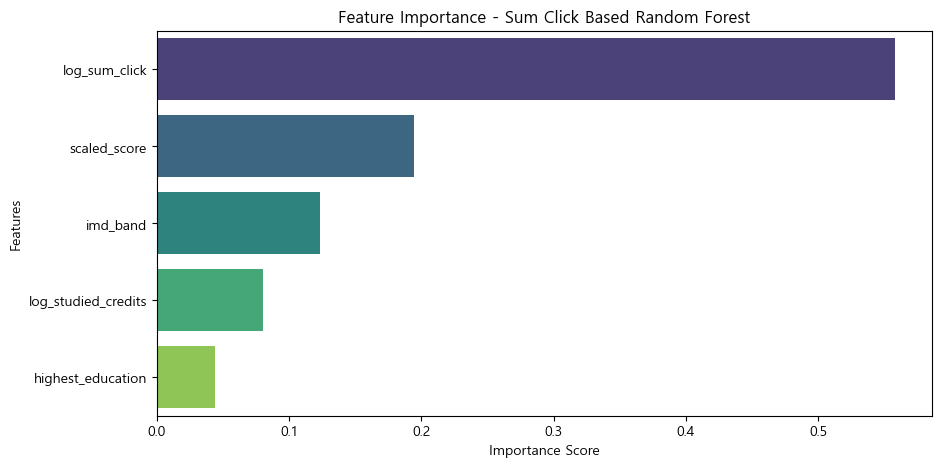

C:\Users\Playdata\AppData\Local\Temp\ipykernel_21652\3517637958.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances_mean, y=feature_importances_mean.index, palette='viridis')


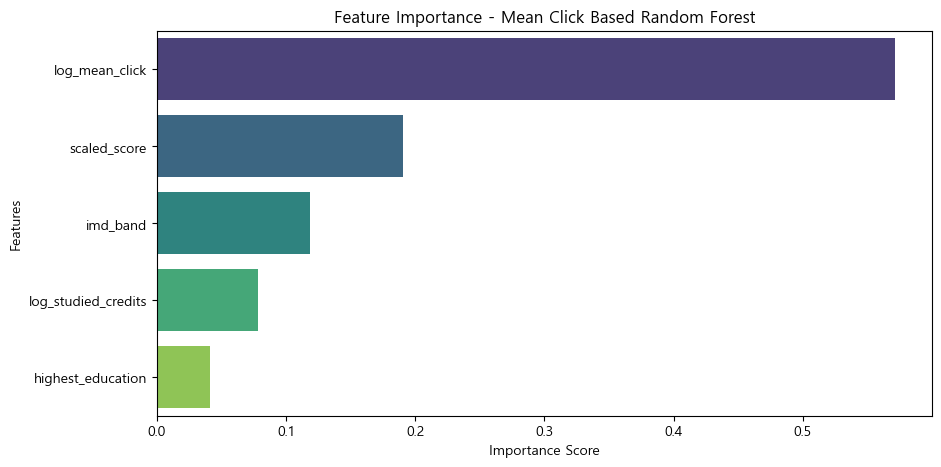

In [ ]:
best_sum_params = {
    'max_depth': 20,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 300,
    'random_state': 42
}

best_mean_params = {
    'max_depth': 20,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 300,
    'random_state': 42
}

turned_rf_sum_model = RandomForestClassifier(**best_sum_params)
turned_rf_sum_model.fit(sum_x_train, y_train)
y_pred_best_sum = turned_rf_sum_model.predict(sum_x_test)

turned_rf_mean_model = RandomForestClassifier(**best_mean_params)
turned_rf_mean_model.fit(mean_x_train, y_train)
y_pred_best_mean = turned_rf_mean_model.predict(mean_x_test)

evaluate_model("Best Sum Click 기반 Random Forest", y_test, y_pred_best_sum)
evaluate_model("Best Mean Click 기반 Random Forest", y_test, y_pred_best_mean)

plt.figure(figsize=(10, 5))
feature_importances_sum = pd.Series(turned_rf_sum_model.feature_importances_, index=sum_clicked_features).sort_values(ascending=False)
sns.barplot(x=feature_importances_sum, y=feature_importances_sum.index, palette='viridis')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance - Sum Click Based Random Forest")
plt.show()

plt.figure(figsize=(10, 5))
feature_importances_mean = pd.Series(turned_rf_mean_model.feature_importances_, index=mean_clicked_features).sort_values(ascending=False)
sns.barplot(x=feature_importances_mean, y=feature_importances_mean.index, palette='viridis')
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance - Mean Click Based Random Forest")
plt.show()


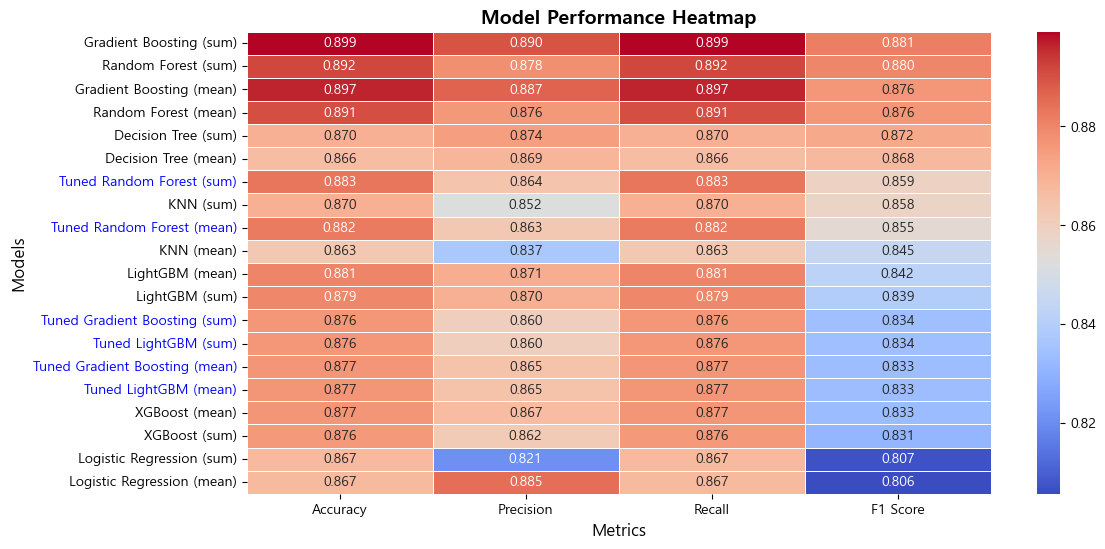

In [ ]:
tuned_models_results = [
    ("Tuned Gradient Boosting (sum)", y_test, y_pred_best_sum),
    ("Tuned Gradient Boosting (mean)", y_test, y_pred_best_mean),
    ("Tuned LightGBM (sum)", y_test, turned_lgbm_sum_model.predict(sum_x_test)),
    ("Tuned LightGBM (mean)", y_test, turned_lgbm_mean_model.predict(mean_x_test)),
    ("Tuned Random Forest (sum)", y_test, turned_rf_sum_model.predict(sum_x_test)),
    ("Tuned Random Forest (mean)", y_test, turned_rf_mean_model.predict(mean_x_test))
]

tuned_model_results = []

for model_name, y_test, y_pred in tuned_models_results:
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    tuned_model_results.append([model_name, accuracy, precision, recall, f1])

tuned_metrics_df = pd.DataFrame(tuned_model_results, columns=["Model", "Accuracy", "Precision", "Recall", "F1 Score"])
merged_metrics_df = pd.concat([metrics_df, tuned_metrics_df], ignore_index=True)

metrics_df_numeric = merged_metrics_df.set_index("Model").select_dtypes(include=["number"])
metrics_df_numeric = metrics_df_numeric.sort_values(by="F1 Score", ascending=False)

plt.figure(figsize=(12, 6))
ax = sns.heatmap(metrics_df_numeric, annot=True, fmt=".3f", cmap="coolwarm", linewidths=0.5, cbar=True)

tuned_model_names = tuned_metrics_df["Model"].tolist()

for label in ax.get_yticklabels():
    if label.get_text() in tuned_model_names:
        label.set_color("blue")  

plt.title("Model Performance Heatmap", fontsize=14, fontweight='bold')
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Models", fontsize=12)

plt.show()


In [ ]:
from sklearn.ensemble import StackingClassifier

base_learners = [
    ('rf', rf_model),
    ('gbm', gbm_model),
    ('dt', dt_model),
    ('knn', knn_model),
    ('xgb', xgb_model),
    ('lgbm', lgbm_model),
    ('lr', lr_model),
    ('tuned_gbm_sum', tuned_gbm_sum_model),
    ('tuned_gbm_mean', tuned_gbm_mean_model),
    ('tuned_lgbm_sum', turned_lgbm_sum_model),
    ('tuned_lgbm_mean', turned_lgbm_mean_model),
    ('tuned_rf_sum', turned_rf_sum_model),
    ('tuned_rf_mean', turned_rf_mean_model)
]

meta_model = XGBClassifier(eval_metric='mlogloss', use_label_encoder=False, random_state=42)

stacking_clf = StackingClassifier(estimators=base_learners, final_estimator=meta_model, passthrough=True)

sum_stacking_clf = stacking_clf.fit(sum_x_train, y_train)
sum_y_pred = sum_stacking_clf.predict(sum_x_test)
sum_result = evaluate_clf(y_test, sum_y_pred)

mean_stacking_clf = stacking_clf.fit(mean_x_train, y_train)
mean_y_pred = mean_stacking_clf.predict(mean_x_test)
mean_result = evaluate_clf(y_test, mean_y_pred)


c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:49:21] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 144286, number of negative: 22138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001093 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 166424, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.866978 -> initscore=1.874502
[Ligh

c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:59:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:59:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:59:08] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 115428, number of negative: 17711
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001415 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 133139, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.866974 -> initscore=1.874461
[Ligh

c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:19:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
정확도 평가
Accuracy : 0.9490049751243781
F1 Score : 0.9481838492781772
Precision : 0.9477188673254507
Recall : 0.9490049751243781


c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:20:33] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 144286, number of negative: 22138
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000862 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 420
[LightGBM] [Info] Number of data points in the train set: 166424, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.866978 -> initscore=1.874502
[Ligh

c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:30:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are

[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Number of positive: 115428, number of negative: 17711
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 419
[LightGBM] [Info] Number of data points in the train set: 133139, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.866974 -> initscore=1.874461
[Ligh

c:\Users\Playdata\AppData\Local\anaconda3\envs\sky_env\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:52:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
정확도 평가
Accuracy : 0.9528444732857452
F1 Score : 0.9523343260898892
Precision : 0.9519892651277462
Recall : 0.9528444732857452
📌 Stacking Model (Sum 기반) 결과: None
📌 Stacking Model (Mean 기반) 결과: None


In [ ]:
from sklearn.metrics import roc_curve, auc

sum_y_proba = sum_stacking_clf.predict_proba(sum_x_test)[:, 1]
mean_y_proba = mean_stacking_clf.predict_proba(mean_x_test)[:, 1]

fpr_sum, tpr_sum, _ = roc_curve(y_test, sum_y_proba)
roc_auc_sum = auc(fpr_sum, tpr_sum)

fpr_mean, tpr_mean, _ = roc_curve(y_test, mean_y_proba)
roc_auc_mean = auc(fpr_mean, tpr_mean)

plt.figure(figsize=(7, 5))
plt.plot(fpr_sum, tpr_sum, color='blue', lw=2, label=f'Sum Click ROC curve (area = {roc_auc_sum:.2f})')
plt.plot(fpr_mean, tpr_mean, color='red', lw=2, label=f'Mean Click ROC curve (area = {roc_auc_mean:.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Sum Click vs. Mean Click (Stacking Classifier)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()